In [1]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import re
import time
from functools import wraps
from warnings import filterwarnings

In [2]:
filterwarnings("ignore",category=FutureWarning)
filterwarnings("ignore",category=UserWarning)
filterwarnings("ignore",category=RuntimeWarning)

def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("Running time: {:.2f} s".format(end-start))
        return result
    return wrapper

In [3]:
conn = sqlite3.connect("anime.db")
db = conn.cursor()

Filtering criteria:
* At least 1000 users rated this anime
* At least 6 episodes
* Score higher than the average (~6.14)
* Started after 1 Jan 2000
* Episodes are longer than 6 minutes
* Dropped some of the second seasons*

\* There are lots of different ways to represent second seasons (an extra dot, exlamation, word, different names, uses of words or numbers - II, 2, etc). It probably can be done programmatically, but it's not yet something I worry about.

In [4]:
## User-Anime Matrix
# Query and filter, create a pivot table, and save it
query = "SELECT ratings.username, anime.title, ratings.my_score FROM ratings \
INNER JOIN anime ON anime.anime_id = ratings.anime_id \
WHERE anime.scored_by>999 \
AND anime.episodes>=6 \
AND anime.start_year>1999 \
AND anime.score > (SELECT AVG(score) FROM anime) \
AND anime.duration > 6"

df = pd.read_sql(query, conn)
# Each user should rate at least 10 anime
df = df.pivot_table("my_score", "username", "title").dropna(thresh=10, axis=0)
# For every user, rate each anime with the user average
df = df.apply(lambda x: x.fillna(x.mean()), axis=0)
# Center the data to zero
# it can make sense to center with axis=0
# (per user) when using algorithm that assume
# standardized data and using users as features
# but the differences are so small it doesn't
# really matter, prediction-wise
df = df.apply(lambda x: x - x.mean(), axis=1)
# drop (some) second seasons
df.drop([x for x in df.columns if '2nd' in x], 1, inplace=True)

df.head()

title,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.,12-sai.: Chicchana Mune no Tokimeki,18if,3-gatsu no Lion,...,"Zone of the Enders: Dolores, I",eX-Driver,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,ēlDLIVE
username,,,,,,,,,,,,,,,,,,,,,
----phoebelyn,0.297022,0.457591,0.570567,-1.339059,0.690890,0.358088,-0.328107,-0.398014,-1.192458,-0.028772,...,-0.647380,0.222162,0.434263,-3.845078,-0.952739,-1.194854,0.445036,0.518316,1.349211,-0.989309
--AnimeBoy--,0.366099,0.526667,0.639644,-1.269983,0.759966,0.427164,-0.259030,-0.328937,-1.123381,0.040305,...,-0.578304,0.291238,0.503340,0.905025,-0.883662,-1.125777,0.514113,0.587393,1.418288,-0.920232
--CyberShadow--,0.089880,0.250449,0.363425,-1.546201,0.483748,0.150945,-0.535249,-0.605156,-1.399600,-0.235914,...,-0.854522,0.015020,0.227121,0.628806,-1.159881,-1.401996,0.237894,0.311174,1.142069,-1.196451
--Etsuko--,0.122444,0.283013,0.395989,-1.513637,0.516312,0.183510,-0.502685,-0.572592,-1.367036,-0.203350,...,-0.821958,0.047584,0.259685,0.661370,-1.127317,-1.369432,0.270458,0.343738,1.174633,-1.163887
--FallenAngel--,-0.302589,2.555310,-0.029044,-1.938671,0.091278,-4.444690,-0.927719,-0.997625,-1.792069,-0.628383,...,-1.246992,-0.377450,5.555310,4.555310,-1.552350,-1.794466,-0.154575,4.555310,4.555310,-1.588921


In [5]:
# RAM in GB and shape
sum(df.memory_usage()) / (1024 ** 3), df.shape

(1.570560447871685, (107935, 1952))

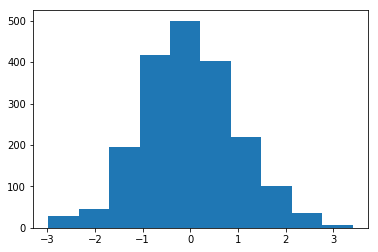

In [6]:
# Distribution of anime avg rating
plt.hist(df.mean(0));

In [7]:
df.mean(0).mean(), df.mean(0).std()

(-0.019791515699426433, 1.0010704444838687)

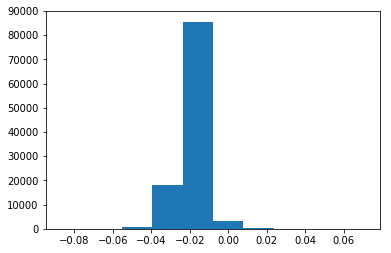

In [8]:
# Distribution of user avg rating
plt.hist(df.mean(1));

In [9]:
df.mean(1).mean(), df.mean(1).std()

(-0.019791515699426453, 0.006183778124192895)

In [10]:
def get_n_similar(anime, n=10):
    """Correlation based recommendations"""
    anime_vector = df[anime]
    # Score similarity by (pearson) correlation
    similar_to_anime = df.corrwith(anime_vector, 0)
    # Convert to DataFrame
    similar_to_anime = pd.DataFrame(similar_to_anime, columns=["Correlation"])
    
    return similar_to_anime.sort_values("Correlation", ascending=False).head(n)

In [11]:
# Action, Fantasy
get_n_similar("Shingeki no Kyojin")

,Correlation
title,
Shingeki no Kyojin,1.000000
Sword Art Online,0.299421
Tokyo Ghoul,0.269979
Mirai Nikki (TV),0.223048
One Punch Man,0.219901
No Game No Life,0.219481
Death Note,0.217761
Noragami,0.205790
Ao no Exorcist,0.199548


In [12]:
# Comedy
get_n_similar("Beelzebub")

,Correlation
title,
Beelzebub,1.000000
SKET Dance,0.165105
Fairy Tail,0.163562
Ao no Exorcist,0.160859
Katekyo Hitman Reborn!,0.157573
Bakuman.,0.151900
Nurarihyon no Mago,0.144555
Kore wa Zombie Desu ka?,0.132752
Bleach,0.132165


In [13]:
# Romance, Shoujo
get_n_similar("Lovely★Complex", 20)

,Correlation
title,
Lovely★Complex,1.000000
Kimi ni Todoke,0.251998
Bokura ga Ita,0.217356
Itazura na Kiss,0.216935
Ouran Koukou Host Club,0.193502
Special A,0.190128
Skip Beat!,0.185110
Nana,0.177403
Kaichou wa Maid-sama!,0.175749


In [26]:
@timer
def get_similar_many(anime_list=["Ao Haru Ride", "Lovely★Complex"], n=30, r=30, criterion='avg'):
    """
    Works by calculating correlations of all movies with each movie and then
    averages these correlations. It returns the sorted 
    """
    lists = defaultdict(list)
    for anime in anime_list:
        results = get_n_similar(anime, r).to_dict()["Correlation"]
        for k,v in results.items():
            lists[k].append(v)
           
    func = max if criterion=='max' else lambda x: sum(x)/len(x)
        
    all_anime = {}
    for k, vs in lists.items():
        if k not in anime_list:
            all_anime[k] = func(vs)
        
    return pd.DataFrame(all_anime, index=["kmourat"]).T.sort_values("kmourat",ascending=False).head(n)

In [27]:
Stergios = ["Fate/stay night: Unlimited Blade Works", "Shingeki no Kyojin", "Fate/Zero",
            "Bleach", "Akame ga Kill!", "Sword Art Online", "Sword Art Online II"]

In [28]:
# AVG
get_similar_many(Stergios, 5, 5, criterion='max')

Running time: 8.52 s


,kmourat
Naruto,0.314530
Naruto: Shippuuden,0.307919
Tokyo Ghoul,0.288006
Black Bullet,0.268690
No Game No Life,0.263537


In [17]:
# MAX
get_similar_many(Stergios, 15, 30, criterion='avg')

Running time: 68.21 s


Naruto: Shippuuden                                          0.308070
Tokyo Ghoul                                                 0.260219
Naruto                                                      0.219907
No Game No Life                                             0.214734
Death Note                                                  0.208298
Accel World                                                 0.208298
Tokyo Ghoul √A                                              0.208219
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka    0.206279
Fullmetal Alchemist                                         0.205094
Mirai Nikki (TV)                                            0.204021
Black Bullet                                                0.201457
Fairy Tail                                                  0.198720
Ao no Exorcist                                              0.195588
Highschool of the Dead                                      0.194953
High School DxD                   

In [18]:
genres = pd.read_sql("SELECT * FROM genres", conn).drop('index', 1).set_index("title").loc[df.columns]
genres.head()

,Police,Shoujo,Dementia,Kids,Music,Super Power,Thriller,Mecha,Ecchi,Samurai,...,Hentai,Yuri,Vampire,Parody,Horror,Action,Historical,Comedy,Slice of Life,Yaoi
title,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Sign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Tasogare no Udewa Densetsu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
009-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
07-Ghost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
sum(genres.memory_usage()) / (1024 ** 2)

0.6749725341796875

In [20]:
def get_user_preferences(anime_list):
    gen = np.zeros(44)
    for anime in anime_list:
        # get genres for each of the anime
        gen += genres.loc[anime]
        
    return gen / len(anime_list)

@timer
def get_suggestions_for_user(anime_list, n=10):
    user_vec = get_user_preferences(anime_list)
    corrs = np.corrcoef(genres, user_vec)[:-1,-1]
    udf = pd.DataFrame(corrs, columns=["Correlations"], index=genres.index)
    udf = udf[~udf.index.isin(anime_list)]
    
    return udf.sort_values("Correlations", ascending=False).head(n)

In [21]:
get_suggestions_for_user(Stergios)

Running time: 0.03 s


,Correlations
title,
Nanatsu no Taizai: Imashime no Fukkatsu,0.831945
Saint Seiya Omega,0.826851
Tsubasa Chronicle,0.826486
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka Gaiden: Sword Oratoria,0.820044
Murder Princess,0.820044
Seiken no Blacksmith,0.820044
Juuni Kokuki,0.801897
Magi: Sinbad no Bouken (TV),0.801897
Bakugan Battle Brawlers: Gundalian Invaders,0.801897


In [22]:
marc = "Devil May Cry, Ao no Exorcist, Naruto, Bleach, Beelzebub, Hellsing, Owari no Seraph, Death Note"
marc = marc.split(", ")
get_suggestions_for_user(marc, 20)

Running time: 0.04 s


,Correlations
title,
Nurarihyon no Mago: Sennen Makyou,0.855489
Nurarihyon no Mago,0.855489
Zettai Karen Children,0.855489
Ushio to Tora (TV),0.837292
Kuroshitsuji II,0.837292
Ao no Exorcist: Kyoto Fujouou-hen,0.818729
Noragami,0.818729
Noragami Aragoto,0.818729
Soul Eater,0.818729


In [23]:
kostas = """Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.
Girls & Panzer
Log Horizon
Steins;Gate
Accel World
Rakudai Kishi no Cavalry
No Game No Life
Akatsuki no Yona
Usagi Drop
Kill la Kill
Sakurasou no Pet na Kanojo
Tengen Toppa Gurren Lagann
Shingeki no Kyojin
Angel Beats!
Ao Haru Ride
Toradora!
Shimoneta to Iu Gainen ga Sonzai Shinai Taikutsu na Sekai
Shigatsu wa Kimi no Uso
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka
Yahari Ore no Seishun Love Comedy wa Machigatteiru.
Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku
Tonari no Kaibutsu-kun
Hunter x Hunter (2011)
Death Parade
NHK ni Youkoso!
One Punch Man
Oda Nobuna no Yabou
Hyouka
Flying Witch
Samurai Champloo
Bokura ga Ita
Shirobako
Kokoro Connect
Ergo Proxy
Shaman King
K-On!
K-On!!
Sword Art Online
So Ra No Wo To
High School DxD
Sankarea
Hataraku Maou-sama!
Mawaru Penguindrum
Kuzu no Honkai
Zankyou no Terror
Hibike! Euphonium
Ore no Imouto ga Konnani Kawaii Wake ga Nai
Ore no Imouto ga Konnani Kawaii Wake ga Nai.
Kono Subarashii Sekai ni Shukufuku wo!
Hai to Gensou no Grimgar
Nanatsu no Taizai
Akame ga Kill!
Kyoukai no Kanata
Blood Lad
Panty & Stocking with Garterbelt
Fullmetal Alchemist: Brotherhood
Golden Time
Sukitte Ii na yo.
Fune wo Amu
Isshuukan Friends.
Sengoku Basara
Brave 10
Sakamichi no Apollon
Kiss x Sis
Kiss x Sis (TV)
Black Lagoon
Guilty Crown
Servant x Service
Mangaka-san to Assistant-san to The Animation
Ore Monogatari!!
Ano Natsu de Matteru
Masamune-kun no Revenge
Ookami Shoujo to Kuro Ouji
Itsudatte Bokura no Koi wa 10 cm Datta."""

In [24]:
kostas = kostas.split("\n")
len(kostas)

74

In [25]:
# VERY fast, even for MANY seen and MANY suggestions
feature_based = get_suggestions_for_user(kostas, 25)
feature_based

Running time: 0.04 s


,Correlations
title,
Chuunibyou demo Koi ga Shitai!,0.827146
I My Me! Strawberry Eggs,0.827146
Chuunibyou demo Koi ga Shitai! Ren,0.827146
Clannad,0.806511
Little Busters!: Refrain,0.806511
Little Busters!: EX,0.806511
Kimi to Boku.,0.793402
Kimi to Boku. 2,0.793402
Otome wa Boku ni Koishiteru,0.793111


In [26]:
# VERY slow, ESPECIALLY for MANY seen (x 10 sec each)
# If saved, can be accessed quickly
cbbased = get_similar_many(kostas, 15, 10)
cbbased

Running time: 729.57 s


Black Lagoon: The Second Barrage                          0.510376
High School DxD New                                       0.441550
Gakusen Toshi Asterisk                                    0.410809
Sengoku Basara Two                                        0.381022
Kono Subarashii Sekai ni Shukufuku wo! 2                  0.303411
Hibike! Euphonium 2                                       0.287759
Sword Art Online II                                       0.281248
Shinmai Maou no Testament                                 0.281229
Taimadou Gakuen 35 Shiken Shoutai                         0.274210
High School DxD BorN                                      0.263445
Monster Musume no Iru Nichijou                            0.262600
Campione!: Matsurowanu Kamigami to Kamigoroshi no Maou    0.260912
Kami nomi zo Shiru Sekai                                  0.258459
Saijaku Muhai no Bahamut                                  0.256344
Trinity Seven                                             0.25

In [29]:
# Timing this, it takes <3.5 sec
corrs = np.corrcoef(df.T)
corrs = pd.DataFrame(corrs, index=df.columns, columns=df.columns)

In [30]:
corrs

title,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.,12-sai.: Chicchana Mune no Tokimeki,18if,3-gatsu no Lion,...,"Zone of the Enders: Dolores, I",eX-Driver,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,ēlDLIVE
title,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,1.000000,0.352320,0.457290,0.077068,0.048405,0.026286,0.026199,0.007560,0.000507,-0.036125,...,0.046148,0.051740,0.014000,0.008235,0.029447,0.046685,0.084452,0.037328,0.044933,-0.004627
.hack//Sign,0.352320,1.000000,0.334541,0.015705,0.050545,0.032366,-0.046054,-0.046607,-0.035990,-0.021488,...,-0.009684,-0.019309,0.023479,0.044686,-0.055995,0.005530,0.114248,0.069535,0.031356,-0.042758
.hack//Tasogare no Udewa Densetsu,0.457290,0.334541,1.000000,0.086460,0.030591,0.015985,0.055431,0.026666,0.012962,-0.043509,...,0.068460,0.078385,0.000337,-0.003658,0.064280,0.051372,0.086866,0.016297,0.028309,0.004578
009-1,0.077068,0.015705,0.086460,1.000000,-0.021149,-0.044769,0.254326,0.170999,0.154647,-0.058657,...,0.266821,0.261702,-0.055841,-0.084308,0.322338,0.153941,0.039142,-0.058261,-0.030680,0.106458
07-Ghost,0.048405,0.050545,0.030591,-0.021149,1.000000,0.107267,-0.048484,-0.045655,-0.050796,-0.025346,...,-0.044199,-0.054048,0.016729,0.021461,-0.077214,-0.023480,0.020299,0.068730,0.057701,-0.042173
11eyes,0.026286,0.032366,0.015985,-0.044769,0.107267,1.000000,-0.082793,-0.065567,-0.066681,-0.035366,...,-0.082199,-0.082450,0.041444,0.047709,-0.115472,-0.036821,0.001176,0.026366,0.008706,-0.058145
12-sai.,0.026199,-0.046054,0.055431,0.254326,-0.048484,-0.082793,1.000000,0.332870,0.212138,-0.050021,...,0.277576,0.311709,-0.081483,-0.123045,0.435921,0.173176,-0.000843,-0.114194,-0.058124,0.171088
12-sai.: Chicchana Mune no Tokimeki,0.007560,-0.046607,0.026666,0.170999,-0.045655,-0.065567,0.332870,1.000000,0.205863,0.001109,...,0.190426,0.209854,-0.071936,-0.099889,0.299830,0.114759,-0.013483,-0.100614,-0.061164,0.180368
18if,0.000507,-0.035990,0.012962,0.154647,-0.050796,-0.066681,0.212138,0.205863,1.000000,0.026985,...,0.170786,0.184061,-0.075634,-0.101010,0.268250,0.081804,-0.011747,-0.089265,-0.059940,0.223106


In [31]:
corrs.shape, sum(corrs.memory_usage()) / (1024 ** 2)

((1965, 1965), 29.551925659179688)

Let's see how fast we can do it with precomputed features

In [31]:
@timer
def get_similar_many2(anime_list=["Ao Haru Ride", "Lovely★Complex"], n=10, criterion='avg'):
    """
    Works by just like the previous one, but with much cleaner code 
    and using the precomputed correlations 
    """
    
    results = corrs[anime_list]
           
    if criterion=='avg':
        return results[~results.index.isin(anime_list)].mean(1).sort_values(ascending=False).head(n)
    else:
        return results[~results.index.isin(anime_list)].max(1).sort_values(ascending=False).head(n)

In [37]:
res = get_similar_many2(Stergios, n=20, criterion='avg')
res

Running time: 0.00 s


title
No Game No Life                                             0.195675
Tokyo Ghoul                                                 0.191963
Mirai Nikki (TV)                                            0.165111
Guilty Crown                                                0.159770
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka    0.159339
Black Bullet                                                0.153413
Noragami                                                    0.153156
Kiseijuu: Sei no Kakuritsu                                  0.151881
One Punch Man                                               0.151826
Tokyo Ghoul √A                                              0.151674
Highschool of the Dead                                      0.150676
Ao no Exorcist                                              0.149663
Hataraku Maou-sama!                                         0.148800
Fairy Tail                                                  0.145198
Log Horizon                 

In [38]:
pd.DataFrame(res, columns=)

,0
title,
No Game No Life,0.195675
Tokyo Ghoul,0.191963
Mirai Nikki (TV),0.165111
Guilty Crown,0.159770
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka,0.159339
Black Bullet,0.153413
Noragami,0.153156
Kiseijuu: Sei no Kakuritsu,0.151881
One Punch Man,0.151826


In [30]:
get_similar_many2(kostas, n=20, criterion='avg')

Running time: 0.01 s


title
Chuunibyou demo Koi ga Shitai!                0.110816
Nisekoi                                       0.110414
Noragami                                      0.102335
Boku wa Tomodachi ga Sukunai                  0.101087
Black Bullet                                  0.094654
Shokugeki no Souma                            0.093688
Mirai Nikki (TV)                              0.093267
Btooom!                                       0.092872
Date A Live                                   0.091616
Charlotte                                     0.091458
Kiseijuu: Sei no Kakuritsu                    0.091117
Gekkan Shoujo Nozaki-kun                      0.090549
Amagi Brilliant Park                          0.090213
Tokyo Ghoul                                   0.089263
Gate: Jieitai Kanochi nite, Kaku Tatakaeri    0.088907
Mahouka Koukou no Rettousei                   0.088800
Kami nomi zo Shiru Sekai                      0.088297
Sword Art Online II                           0.088235
Psyc